In [2]:
import os
import numpy as np
import glob
import csv
import matplotlib
import glob
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
import scipy
import patsy
%matplotlib inline


//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


ALL THE SUBJECTS

In [90]:
home_dir = '/Users/ianballard/Dropbox/two_step_analysis/' #where the data live
path = home_dir + '/modeling/'

ignore_files = ['bonuses.csv','A1DS5O8MSI3ZH0.csv','A2C39KTRMOM1XZ.csv','all_data.csv']
data_files = glob.glob(home_dir + '*csv')
data_files = [d for d in data_files if d.split('/')[-1] not in ignore_files]
sub_ids = map(lambda f: f.split('/')[-1].split('.csv')[0],data_files)
print(len(data_files))

101


In [91]:
ntrials = 200 
key_map = {37:0,39:1} #keystrokes. Remember that the location of the stimuli changes trial to trial
state_map = {'3,2':1,'5,4':2,'2,3':1,'4,5':2} #
practice = ['practice_first_stage', 'practice_second_stage', 'practice_FB_stage'] #labels for practice trials
missed_responses = {}
all_data = []

for i,f in enumerate(data_files):
    if True:
        sub_id = sub_ids[i] #parse subid from filename
        missed_responses[sub_id] = 0
        #dictionary to fill. Shift rew and ttype so [rew,ttype][n-1] corresponds to stay[n].
        data = {'rt1':[],'rt2':[],'action1':[],'action2':[],'choice1':[],
                'choice2':[],'state':[],'rew':[np.NaN],'ttype':[np.NaN],'stay':[],
                'correct':[np.NaN],'sub':[]} 

        #preprocess data
        df = pd.read_csv(f) 
        df = df.drop(['view_history','stimulus','internal_chunk_id'],1) #drop useless columns

        #drop practice trials
        for t in practice: 
            df = df[df['trial_id'] != t]

        #get choices, actions, rewards, RTs, etc from each trial
        for j in range(ntrials): 
            trial_df = df[df['trial_num'] == j] #get data corresponding to that trial
            if len(trial_df) == 3 and trial_df['key_press'].values[0] != -1 and trial_df['key_press'].values[1] != -1: 
                state = state_map[str(trial_df['condition'].values[1])]
                data['rt1'].append(trial_df['rt'].values[0])
                data['rt2'].append(trial_df['rt'].values[1])
                data['rew'].append(float(trial_df['condition'].values[2])) 
                data['state'].append(state)

                action1 = key_map[trial_df['key_press'].values[0]]
                action2 = key_map[trial_df['key_press'].values[1]]
                choice1 = int(trial_df['condition'].values[0].split(',')[action1])
                choice2 = int(trial_df['condition'].values[1].split(',')[action2])

                #determine if it was a switch or stay trial
                if len(data['choice1'])>0 and (choice1 == data['choice1'][-1]):
                    data['stay'].append('stay')
                else:
                    data['stay'].append('switch')
                    
                #determine if choice was "correct"
                fb_probs = trial_df['FB_probs'].values[2].split(',')
                fb_probs = map(float,fb_probs)
                max_vals = max(fb_probs[0:2]),max(fb_probs[2:4])
                max_state = max_vals.index(max(max_vals))
                correct = int(choice1 == max_state)
                
                #add values to dictionary
                data['correct'].append(correct)
                data['action1'].append(action1)
                data['action2'].append(action2)
                data['choice1'].append(choice1)
                data['choice2'].append(choice2)

                #determine if it was a common or rare transition
                if (choice1 == 0 and state == 1) or (choice1 == 1 and state == 2):
                    data['ttype'].append('common')
                else:
                    data['ttype'].append('rare')
            else:
                missed_responses[sub_id] +=1

        data['sub'] = [sub_id] * len(data['rt1'])

        data['rew'] = data['rew'][:-1] #doesnt matter for prediction stay shift of next trial
        data['ttype'] = data['ttype'][:-1]#doesnt matter for prediction stay shift of next trial
        data['correct'] = data['correct'][:-1]#doesnt matter for prediction stay shift of next trial

        data = pd.DataFrame(data) #make dataFrame
        all_data.append(data)
    
#print len(all_data)   
all_data = pd.concat(all_data)
all_data = all_data.dropna() #drop the first trial for each subjext

# Subject exclusions

In [92]:
#checks is a big list contains a small list
def contains(small, big):
    for i in xrange(len(big)-len(small)+1):
        for j in xrange(len(small)):
            if big[i+j] != small[j]:
                break
        else:
            return i, i+len(small)
    return False

In [93]:
bad_subs = set()

In [94]:
#random responding
bad_length = 20
bad_strings = [[37.0]*bad_length,[39.0]*bad_length, [37.0,39.0] *(bad_length/2)]

for s in sub_ids:
    for bad_str in bad_strings:
        if contains(bad_str,key_presses[s]):
            bad_subs.add(s)

In [95]:
#missed responses
for s in missed_responses.keys():
    if missed_responses[s] > 10:
        bad_subs.add(s)

In [96]:
#drop bad subjects
sub_ids = [s for s in sub_ids if s not in bad_subs]
print len(sub_ids)

76


In [97]:
# for s in sub_ids:
#     all_data = all_data[all_data['sub'] != s]

# Switch/Stay Analysis

In [98]:
for i in range(len(sub_ids)):
    prob_stay = []
    
    sub_id = sub_ids[i]
    this_data = all_data[all_data['sub'] == sub_id]
    #ax = plt.subplot(4,4,i+1)

    for outcome in (1,0):
        for ttype in ("common", "rare"):
            #print '%s %s' % (outcome, ttype)
            
            trials = this_data[this_data['rew'] == outcome]
            trials = trials[trials['ttype'] == ttype]
        
            total_num_trials = len(trials)
            trials = trials[trials['stay'] == 'stay']
            num_stay = len(trials)
        
            prob_stay.append(float(num_stay) / float(total_num_trials))
        
#     print sub_ids[i],",%.3f,%.3f,%.3f,%.3f" % (prob_stay[0], prob_stay[1], prob_stay[2], prob_stay[3])    
    #ax.bar(range(4), prob_stay)

             action1   action2   choice1   choice2   correct         rt1  \
ttype  rew                                                                 
common 0    0.490280  0.500361  0.466387  3.468553  0.477242  512.444242   
       1    0.484012  0.509925  0.462527  3.453646  0.577609  525.770325   
rare   0    0.498785  0.491885  0.483040  3.467217  0.567985  521.500422   
       1    0.480161  0.520363  0.492792  3.479662  0.478435  532.236612   

                   rt2     state  stay_indicator  
ttype  rew                                        
common 0    539.344554  1.481767        0.594835  
       1    543.251851  1.480617        0.659028  
rare   0    553.169192  1.487241        0.611414  
       1    554.688113  1.486402        0.634523  


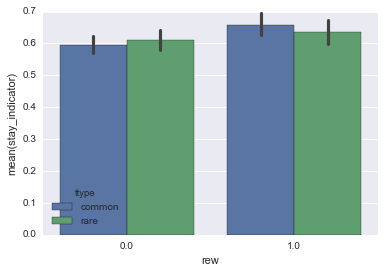

In [99]:
##make summary plot
stay_map = {'switch':0,'stay':1}
stay_binary = map(lambda x: stay_map[x], all_data['stay'].values)
all_data['stay_indicator'] = stay_binary
df = all_data.groupby(['ttype','rew','sub']).mean()
df.reset_index(inplace=True)  
sns.barplot(x = 'rew',y='stay_indicator',hue = 'ttype',data = df )
print df.groupby(['ttype','rew']).mean()

In [100]:
# #calculate bonus for each subject (bonuses) 
# all_data.groupby(['sub']).sum()['rew'] * .02
# bonuses = all_data.groupby(['sub']).sum()['rew'] * .02
# bonuses = bonuses.reset_index()  
# bonuses['Assignment'] = np.NaN
# worker_data = pd.read_csv('transaction_data/Transactions_2016-01-18_to_2016-03-03.csv')
# for sub in bonuses['sub']:
#     assignment_id = worker_data[worker_data['Recipient ID'] == sub]['Assignment ID']
#     if len(assignment_id) > 0:
#         assignment_id = np.array(assignment_id)[0]
#         bonuses.ix[bonuses['sub'] == sub,'Assignment'] = assignment_id
#     else:
#         print sub
# bonuses = bonuses.dropna()
# bonuses = bonuses.drop_duplicates()
# # bonuses.to_csv('bonuses.csv',columns = ['Assignment','sub','rew'],header = False, index = False)

payments = pd.read_csv(home_dir + '/transaction_data/logs_for_tamara_3_30.csv')
payments = payments.sort('Transaction Type')
payments.to_csv(home_dir + '/transaction_data/logs_for_tamara_3_30_sorted.csv')
print payments.groupby('Transaction Type').sum()

                   Amount
Transaction Type         
AssignmentPayment  -57.00
BonusPayment      -464.10
FeePayment        -104.26


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


# Logistic Regression Analysis

In [101]:
#normalize regressors
stay_map = {'common':.5,'rare':-.5}
all_data['ttype_bin'] = map(lambda x: stay_map[x],all_data['ttype'])
all_data['rew'] = all_data['rew'] - .5
all_data['correct'] = all_data['correct'] - .5

In [102]:
#logistic regression analysis
ttype_betas = []
stay_betas = []
rew_betas = []
intercept_betas = []
interaction_betas = []
correct_betas = []
score = []

      
for n,sub in enumerate(sub_ids):
    sub_data = all_data[all_data['sub'] == sub] 

    y, X = dmatrices('stay_indicator ~ ttype_bin + rew + rew:ttype_bin + correct',
                 sub_data,return_type="dataframe")

    #normalize (except the intercept)
    X = patsy.standardize(X)
    X['Intercept'] = 1

    y = np.ravel(y)
    model = LogisticRegression()
    model = model.fit(X, y)

    # betas = pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))
    score.append(model.score(X, y))
    coef = model.coef_[0]
    intercept_betas.append(coef[0])
    ttype_betas.append(coef[1])
    rew_betas.append(coef[2])
    interaction_betas.append(coef[3])
    correct_betas.append(coef[4])

In [103]:
t,p = scipy.stats.ttest_1samp(ttype_betas,0)
print 'ttype',t,p

t,p = scipy.stats.ttest_1samp(intercept_betas,0)
print 'intercept',t,p

t,p = scipy.stats.ttest_1samp(rew_betas,0)
print 'rew',t,p

t,p = scipy.stats.ttest_1samp(interaction_betas,0)
print 'interaction',np.mean(interaction_betas),t,p

t,p = scipy.stats.ttest_1samp(correct_betas,0)
print 'correct',np.mean(correct_betas),t,p

t,p = scipy.stats.ttest_1samp(score,.5)
print 'score',np.mean(score),t,p

ttype 1.18996091604 0.237814984117
intercept 7.27599928389 2.81157413195e-10
rew 4.47154345638 2.71225731809e-05
interaction 0.0648472203793 2.30929343613 0.0236824084809
correct 0.0599963497485 2.25636964473 0.0269611828822
score 0.684891107353 12.0501401767 3.23020624125e-19


In [ ]:
ttype 0.864730969804 0.38925609257
intercept 7.45747736317 3.26969150039e-11
rew 4.56927323027 1.40060878182e-05
interaction 0.0553190643411 2.43355446954 0.0167260023547
correct 0.0511303588559 2.23374955596 0.0277270243581
score 0.661784373971 12.8132346458 8.06631142296e-23

(array([  4.,   3.,  11.,  15.,  24.,  22.,  10.,   7.,   2.,   3.]),
 array([-0.50535266, -0.38748248, -0.2696123 , -0.15174212, -0.03387194,
         0.08399824,  0.20186842,  0.31973859,  0.43760877,  0.55547895,
         0.67334913]),
 <a list of 10 Patch objects>)

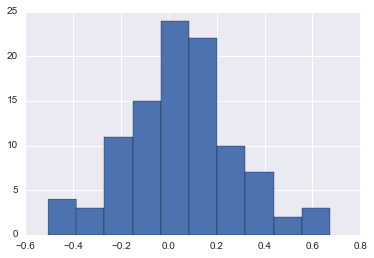

In [10]:
plt.hist(correct_betas)

In [11]:
correct_betas
print np.mean(correct_betas)
print np.std(correct_betas)

0.0511303588559
0.228899245753


In [13]:
rew_betas
print np.mean(rew_betas)
print np.std(rew_betas)

0.150388440442
0.329129891917


In [14]:
ttype_betas
print np.mean(ttype_betas)
print np.std(ttype_betas)

0.0145807403295
0.168615914529


In [15]:
interaction_betas
print np.mean(interaction_betas)
print np.std(interaction_betas)

0.0553190643411
0.227317962403


In [66]:
#probability correct analysis

df = df[FB_probs]
FB_probs = []
df = pd.read_cvs('df[FB_probs]')

for numbers in 'FB_probs':
    state1 = (2, 3)
    state2 = (4, 5)
    
    state1 = 'FB_probs' * ['action1'] or 'FB_probs' * ['action2']
    state2 = 'FB_probs' * ['action2'] or 'FB_probs' * ['action1']
    
    prob_state1 = []
    prob_state2 = [] 
    
    prob_state1 = prob_state1 / prob_state1 + prob_state2 
    prob_state2 = prob_state2 / prob_state1 + prob_state2 
    
    max('prob_state1') #Compute max probability associated with state 1
    max('prob_state2') #Compute max probability associated with state 2
    max('prob_state1' and 'prob_state2') #Compute max probability associated with state 1 and state 2
    
    correct = max('prob_state1' and 'prob_state2')
    
    if action1 or action2 == max('prob_state1' and 'prob_state2'):
        correct == 1
    else:
        correct == 0
     

NameError: name 'FB_probs' is not defined

In [ ]:
#OR?                 
correct = max((choice2 == 0 or 1) and choice1 == 0) or max((choice2 == 0 or 1) and choice1 == 1)

In [1]:
sub_data

NameError: name 'sub_data' is not defined